# <center>NLP: Topic Modeling for Riyadh Newspaper Articles</center>



**DATA**: We are planning to use our previously **scraped** data from the Riyadh Newspaper website **in Arabic**, ~3GB, plus some additional data (MetaData) that could add a meaningful sense to our project, see [Riyadh Newspaper website](http://www.alriyadh.com/1814297) to understand how we scraped the data.

**EXPECTED OUTPUT**: At the end of this project we expect to be done NLP **Topic Modeling** on Riyadh Newspaper articles, and all it's required preproccesing steps in addition to approperiate visualization.

**BONUS TASKS**: 
- Scraping ~3GB Data. 
- Using SQL Database for data storage. 
- As a challenge, we used data written in Arabic.

# 1. Data

In [6]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import unicodedata
import re

import nltk # pip install nltk 
from nltk.tokenize import word_tokenize 
from nltk.tokenize import wordpunct_tokenize 
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.stem.isri import ISRIStemmer

from sklearn.feature_extraction.text import TfidfVectorizer


### Reading From Database

In [7]:
# server = 't5.database.windows.net'
# database = 'T5'
# username = 't5'
# password = 'My404Data'

# # dfs2.columns=dfs2.columns.str.strip()

# cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
# cursor = cnxn.cursor()

In [8]:
# df = pd.read_sql("select * from articles",cnxn)
# df
# df.to_csv("metadata.csv", encoding='utf-8-sig')

In [9]:
# df2= pd.read_sql("select * from texts",cnxn)
# df2
# df2.to_csv("all_texts.csv",encoding='utf-8-sig')

### Reading CSVs Files

### Texts Dataset

In [10]:
df_texts = pd.read_csv('all_texts.csv')

In [11]:
df_texts.head(3)

,Unnamed: 0,T_ID,T_AID,T_Text
0,0,87160,174309,\nعلى الرغم من التحذيرات الشديدة والمتكررة الت...
1,1,87164,174317,\nأدى محافظ ضمد عبدالله خالد البراق عقب صلاة ع...
2,2,87165,174319,\nرفع رئيس مجلس إدارة الهيئة العامة للولاية عل...


In [12]:
df_texts.shape

(283762, 4)

### Metadata  Dataset

In [13]:
df_metadata = pd.read_csv('metadata.csv')

In [14]:
df_metadata.head(3)

,Unnamed: 0,A_ID,A_Link,A_LinkNum,A_Timestr,A_Cat,A_Auth,A_Title1,A_Title2,A_Paragraphs,A_Words,A_Characters
0,0,1,http://www.alriyadh.com/1814297,1814297,&nbsp; \n\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\...,المحليات,"الرياض - ""الرياض""",إلى ما بعد اجتماع مجموعة أوبك بلس,السعودية تؤجل الإعلان عن أسعار الخام لشهر مايو,8,339,1962
1,1,2,http://www.alriyadh.com/1814297,1814297,&nbsp; \n\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\...,المحليات,"الرياض - ""الرياض""",إلى ما بعد اجتماع مجموعة أوبك بلس,السعودية تؤجل الإعلان عن أسعار الخام لشهر مايو,8,339,1962
2,2,3,http://www.alriyadh.com/1814296,1814296,&nbsp; \n\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\...,المحليات,وادي الدواسر - سعود آل مسيب,NaN,تعليم وادي الدواسر يبدأ المرحلة الثانية من خطة...,3,183,1162


In [15]:
df_metadata.shape

(567524, 12)

### Merge  Datasets

In [16]:
df = pd.merge(df_texts, df_metadata, how='inner', left_on='T_AID', right_on='A_ID')
print(df.shape)
df = df[['T_AID', 'A_Link', 'T_Text', 'A_Cat', 'A_Title1', 'A_Title2', 'A_Words']]
df.head(3)

(283762, 16)


,T_AID,A_Link,T_Text,A_Cat,A_Title1,A_Title2,A_Words
0,174309,http://www.alriyadh.com/1718990,\nعلى الرغم من التحذيرات الشديدة والمتكررة الت...,المحليات,متهورون يُلقون بمركباتهم في بطون الأودية الممت...,مغامرات السيول.. إلى متى؟,604
1,174317,http://www.alriyadh.com/1718986,\nأدى محافظ ضمد عبدالله خالد البراق عقب صلاة ع...,المحليات,NaN,محافظ ضمد ينقل تعازي القيادة لذوي الشهيد معافا,139
2,174319,http://www.alriyadh.com/1718985,\nرفع رئيس مجلس إدارة الهيئة العامة للولاية عل...,المحليات,NaN,أعضاء هيئة الولاية على أموال القاصرين: نقدر ال...,646


# 2. EDA

### Missing Values & Duplicates

In [17]:
print(f'Number of missing values is {df.T_Text.isna().sum()}\nNumber of duplicated rows is {df.T_Text.duplicated().sum()}')

Number of missing values is 6216
Number of duplicated rows is 8121


In [18]:
df.dropna(subset=['T_Text'], inplace=True)
df.drop_duplicates(subset=['T_Text'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,T_AID,A_Link,T_Text,A_Cat,A_Title1,A_Title2,A_Words
0,174309,http://www.alriyadh.com/1718990,\nعلى الرغم من التحذيرات الشديدة والمتكررة الت...,المحليات,متهورون يُلقون بمركباتهم في بطون الأودية الممت...,مغامرات السيول.. إلى متى؟,604
1,174317,http://www.alriyadh.com/1718986,\nأدى محافظ ضمد عبدالله خالد البراق عقب صلاة ع...,المحليات,NaN,محافظ ضمد ينقل تعازي القيادة لذوي الشهيد معافا,139
2,174319,http://www.alriyadh.com/1718985,\nرفع رئيس مجلس إدارة الهيئة العامة للولاية عل...,المحليات,NaN,أعضاء هيئة الولاية على أموال القاصرين: نقدر ال...,646
3,174325,http://www.alriyadh.com/1718982,\nوجه صاحب السمو الملكي الأمير د. فيصل بن مشعل...,المحليات,NaN,تشكيل لجانٍ حصر أضرار السيول بالقصيم,165
4,174327,http://www.alriyadh.com/1718981,\nاستقبل صاحب السمو الملكي الأمير فيصل بن خالد...,المحليات,NaN,أمير عسير يستقبل مديرَي مكافحة المخدرات السابق...,79
...,...,...,...,...,...,...,...
275635,385961,http://www.alriyadh.com/1602591,\nأطلقت موبايلي أعمال بالتعاون MachinesTalk خد...,الاقتصاد,NaN,بالتعاون مع MachinesTalk موبايلي أعمال تطلق خد...,210
275636,385963,http://www.alriyadh.com/1602590,\nتتفقد مدير جامعة أم القرى رئيس اللجنة الإشرا...,المحليات,NaN,اللجنة الإشرافية لمشروعات المسجد الحرام تباشر ...,236
275637,385965,http://www.alriyadh.com/1602589,\nاعتبر الخبير الأميركي المتخصص في قضايا الخلي...,الاقتصاد,إشادة دولية بإعادة هيكلة الطريقة التي يعمل بها...,ثيودور كراسيك: فرص الاستثمار في الإسكان تتضاعف...,560
275638,385967,http://www.alriyadh.com/1602588,"\nيتوجه صندوق تنمية الموارد البشرية ""هدف""، إلى...",الاقتصاد,NaN,"""هدف"" يتجه لتقليص\n فروعه وإتاحة خدماته إلكترو...",137


### Articles Lengths (Words)

In [19]:
df[df['A_Words'] == 4].iloc[2]['T_Text']

'\nتكفى يا طائر النورس!'

In [20]:
df[df['A_Words'] == df['A_Words'].max()]['T_Text'][151767]

'\nدعت وزارة الخدمة المدنية (5000) متقدمة على الوظائف المشمولة بلائحة الوظائف التعليمية المعلنة بتاريخ 20-12-1437هـ ، ويمثلن من تم ترشيحهن مبدئياً للمطابقة النهائية لبياناتهن لدى أي من فروع أو مكاتب الوزارة في مختلف مناطق ومحافظات المملكة وذلك اعتباراً من يوم غدٍ الأثنين الموافق 7-2-1438هـ وحتى نهاية دوام يوم الخميس القادم الموافق 10-2-1438هـ  خلال فترة الدوام الرسمي  مصطحبات معهن ما يلي :-\nالهوية الوطنية مع صورة منها ، أو سجل الأسرة المضافة به المتقدمة.\nوثيقة التخرج الأصلية مع صوره منها ، موضحاً فيها التقدير العام والنسبة المئوية أو المعدل التراكمي وتاريخ التخرج بالإضافة الى كشف الدرجات .\nالحاصلات على المؤهلات الخارجية يتطلب منهن إرفاق معادلة لجنة المعادلات بوزارة التعليم مع ارفاق مفاتيح المعدل مع نسخة منها.\nالحاصلات على الدبلوم التربوي يتطلب إرفاق وثيقة الدبلوم العام في التربية مع نسخة منه ، في حال كون المتقدمة تحمل مؤهلاً غير تربوياً.\nالحاصلات على دبلوم التربية الخاصة يتطلب إرفاق وثيقة دبلوم التربية الخاصة مع نسخة منها.\nوتؤكد وزارة الخدمة المدنية إلى أن من لم تحضر أصول الوثائق

In [21]:
def plot_articles_lenghts():
    plt.figure(figsize=(16, 5))
    plt.grid()
    plt.hist(df['A_Words'], bins=70);
    plt.show();

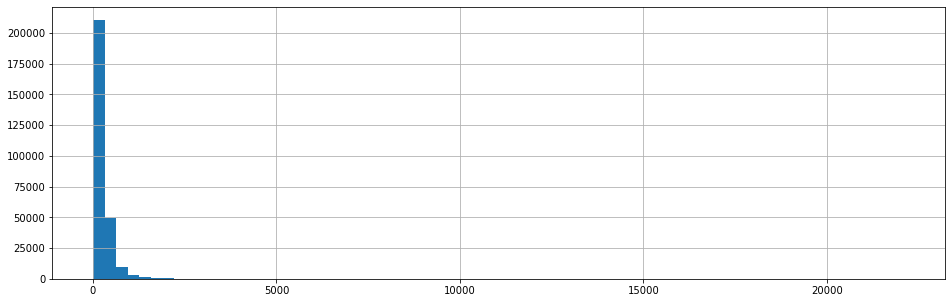

In [22]:
plot_articles_lenghts()

In [23]:
# Wrong Texts (i.e. very long/short texts)
df = df[((df['A_Words'] >= 150) & (df['A_Words'] <= 500))].copy()
df.reset_index(drop=True, inplace=True)

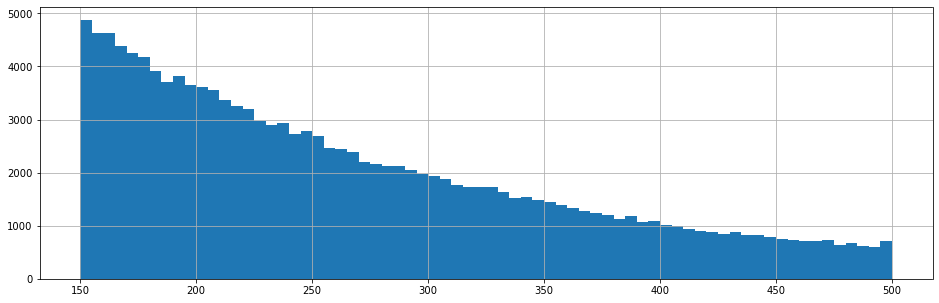

In [24]:
plot_articles_lenghts()

### Cleaning Text

In [25]:
df['T_Text'][8]

'\nرعى وزير التعليم\xa0د. أحمد بن محمد العيسى رئيس المؤتمر العام لمكتب التربية العربي لدول الخليج صباح أمس بمقر وزارة التعليم بالرياض احتفالية جائزة مكتب التربية العربي لدول الخليج للعام 1438 -1439هـ في دورتها التاسعة والتي فازت بها مؤسسة الملك عبدالعزيز ورجاله للموهبة والإبداع "موهبة" في مجال التجارب والمشروعات التعليمية.\nوقد حضر الاحتفالية نائب وزير التعليم د. عبدالرحمن محمد العاصمي، والمدير العام لمكتب التربية العربي لدول الخليج د. علي عبدالخالق القرني، والأمين العام لمؤسسة الملك عبدالعزيز ورجاله للموهبة والإبداع د. سعود بن سعيد المتحمي، وعدد من المسؤولين في وزارة التعليم، ومكتب التربية العربي، ومؤسسة الملك عبدالعزيز ورجاله للموهبة والإبداع.\nوفي بداية الاحتفال شاهد الحضور فيلماً مرئياً عن مراحل تأسيس الجائزة وأبرز الأسماء الفائزة (أفرادا ومؤسسات) وطرق التقديم والتحكيم الإلكتروني.\nإثر ذلك ألقى د. القرني كلمة أوضح فيها أن الجائزة في دورتها التاسعة تأتي في إطار دعم الباحثين والمميزين في مجال الدراسات والمشروعات التربوية، والتي كانت من نصيب مؤسسة الملك عبدالعزيز ورجاله للموهبة والإبد

In [26]:
# remove (\n, \xa0..)
df['T_Text'] = df['T_Text'].apply(lambda x: unicodedata.normalize("NFKC", x.replace('\n', ' '))).astype(str)

# remove (non-arabic-alphabet)
df['T_Text'] = df['T_Text'].str.replace('[^ء-ي ]', '')

# replcae (أ,آ,إ) by (ا)
df['T_Text'] = df['T_Text'].apply(lambda x: re.sub('[أإآ]', 'ا', x))

# replace (ة) by (ه)
df['T_Text'] = df['T_Text'].apply(lambda x: re.sub('[ة]', 'ه', x))

# remove multi spaces
df['T_Text'] = df['T_Text'].apply(lambda x: re.sub(' +', ' ', x).strip())


<ipython-input-26-aa8a2db622b9>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['T_Text'] = df['T_Text'].str.replace('[^ء-ي ]', '')


In [27]:
df['T_Text'][8]

'رعى وزير التعليم د احمد بن محمد العيسى رئيس المؤتمر العام لمكتب التربيه العربي لدول الخليج صباح امس بمقر وزاره التعليم بالرياض احتفاليه جائزه مكتب التربيه العربي لدول الخليج للعام هـ في دورتها التاسعه والتي فازت بها مؤسسه الملك عبدالعزيز ورجاله للموهبه والابداع موهبه في مجال التجارب والمشروعات التعليميه وقد حضر الاحتفاليه نائب وزير التعليم د عبدالرحمن محمد العاصمي والمدير العام لمكتب التربيه العربي لدول الخليج د علي عبدالخالق القرني والامين العام لمؤسسه الملك عبدالعزيز ورجاله للموهبه والابداع د سعود بن سعيد المتحمي وعدد من المسؤولين في وزاره التعليم ومكتب التربيه العربي ومؤسسه الملك عبدالعزيز ورجاله للموهبه والابداع وفي بدايه الاحتفال شاهد الحضور فيلما مرئيا عن مراحل تاسيس الجائزه وابرز الاسماء الفائزه افرادا ومؤسسات وطرق التقديم والتحكيم الالكتروني اثر ذلك القى د القرني كلمه اوضح فيها ان الجائزه في دورتها التاسعه تاتي في اطار دعم الباحثين والمميزين في مجال الدراسات والمشروعات التربويه والتي كانت من نصيب مؤسسه الملك عبدالعزيز ورجاله للموهبه والابداع ونوه القرني بحرص المكتب على تشجيع ا

# 3. Preprocessing

### 3.1. Tokenization

In [28]:
df['T_Text'] = df['T_Text'].apply(lambda x: wordpunct_tokenize(x)).to_numpy()
df['T_Text'][0]

['وجه',
 'صاحب',
 'السمو',
 'الملكي',
 'الامير',
 'د',
 'فيصل',
 'بن',
 'مشعل',
 'بن',
 'سعود',
 'بن',
 'عبدالعزيز',
 'امير',
 'منطقه',
 'القصيم',
 'بتشكيل',
 'ثلاث',
 'لجان',
 'ميدانيه',
 'لحصر',
 'الاضرار',
 'الناجمه',
 'عن',
 'هطول',
 'الامطار',
 'اخيرا',
 'على',
 'مدينه',
 'بريده',
 'والمراكز',
 'التابعه',
 'لها',
 'والتي',
 'نتج',
 'عنها',
 'اضرار',
 'ماديه',
 'في',
 'عدد',
 'من',
 'المساكن',
 'والمركبات',
 'واكد',
 'المتحدث',
 'الرسمي',
 'لاماره',
 'منطقه',
 'القصيم',
 'عبدالرحمن',
 'بن',
 'محمد',
 'السعيد',
 'ان',
 'توجيه',
 'سمو',
 'امير',
 'منطقه',
 'القصيم',
 'نص',
 'على',
 'ان',
 'تبدا',
 'اللجان',
 'المرحله',
 'الاولى',
 'من',
 'العمل',
 'باستقبال',
 'المتضررين',
 'وتسجيل',
 'بياناتهم',
 'بدءا',
 'من',
 'اول',
 'من',
 'امس',
 'السبت',
 'وذلك',
 'بمدينه',
 'الملك',
 'عبدالله',
 'الرياضيه',
 'بمدينه',
 'بريده',
 'ولمده',
 'عشرين',
 'يوما',
 'قادمه',
 'مشيرا',
 'الى',
 'ان',
 'فتره',
 'عمل',
 'اللجان',
 'صباحيه',
 'ومسائيه',
 'بقصد',
 'اعطاء',
 'فرصه',
 'للمتضررين',
 'من',
 'ا

### 3.3. Stop words removal

In [29]:
stop_words = stopwords.words('arabic')
stop_words.extend(['هـ', 'د', 'م', 'الى', 'ان', 'اذ', 'لهذه', 'قال', 'وقال', 'اكد', 'عدد', 'بعدد', 'وعدد'
                  , 'والتي', 'بن', 'بنت', 'وقد', 'ا', 'عبر', 'خلال', 'او', 'الا', 'وان', 'اي', 'بان', 'كان'
                  , 'كانت' ,'تم','الف','مليون', 'وفي', 'وقد','اكثر','اقل', 'انه','وانه', 'قالت', 'وقالت', 'وتم'])

df['T_Text_Clean'] = df['T_Text'].apply(lambda x: [word for word in x if word not in stop_words])


In [30]:
df['T_Text_Clean'][0]

['وجه',
 'صاحب',
 'السمو',
 'الملكي',
 'الامير',
 'فيصل',
 'مشعل',
 'سعود',
 'عبدالعزيز',
 'امير',
 'منطقه',
 'القصيم',
 'بتشكيل',
 'لجان',
 'ميدانيه',
 'لحصر',
 'الاضرار',
 'الناجمه',
 'هطول',
 'الامطار',
 'اخيرا',
 'مدينه',
 'بريده',
 'والمراكز',
 'التابعه',
 'نتج',
 'عنها',
 'اضرار',
 'ماديه',
 'المساكن',
 'والمركبات',
 'واكد',
 'المتحدث',
 'الرسمي',
 'لاماره',
 'منطقه',
 'القصيم',
 'عبدالرحمن',
 'محمد',
 'السعيد',
 'توجيه',
 'سمو',
 'امير',
 'منطقه',
 'القصيم',
 'نص',
 'تبدا',
 'اللجان',
 'المرحله',
 'الاولى',
 'العمل',
 'باستقبال',
 'المتضررين',
 'وتسجيل',
 'بياناتهم',
 'بدءا',
 'اول',
 'امس',
 'السبت',
 'وذلك',
 'بمدينه',
 'الملك',
 'عبدالله',
 'الرياضيه',
 'بمدينه',
 'بريده',
 'ولمده',
 'يوما',
 'قادمه',
 'مشيرا',
 'فتره',
 'عمل',
 'اللجان',
 'صباحيه',
 'ومسائيه',
 'بقصد',
 'اعطاء',
 'فرصه',
 'للمتضررين',
 'الموظفين',
 'المرتبطين',
 'بدوام',
 'صباحي',
 'لافتا',
 'اماره',
 'المنطقه',
 'تهيب',
 'بكافه',
 'المواطنين',
 'التقدم',
 'خلال',
 'الفتره',
 'المحدده',
 'مصطحبين',
 'معهم',


### 3.4. Stemming or Lemmatization

In [31]:
st = ISRIStemmer()

df['T_Text_St'] = df['T_Text_Clean'].apply(lambda x: [st.stem(word) for word in x])
df['T_Text_St'][0]

['وجه',
 'صحب',
 'سمو',
 'لكي',
 'امر',
 'يصل',
 'شعل',
 'سعد',
 'عبدالعزيز',
 'امر',
 'طقه',
 'قصم',
 'شكل',
 'لجن',
 'يدن',
 'حصر',
 'ضرر',
 'نجم',
 'هطل',
 'مطر',
 'اخر',
 'دين',
 'برد',
 'ركز',
 'تبع',
 'نتج',
 'عنه',
 'ضرر',
 'اده',
 'مسا',
 'ركب',
 'وكد',
 'تحدث',
 'رسم',
 'امر',
 'طقه',
 'قصم',
 'عبدالرحمن',
 'حمد',
 'سعد',
 'وجه',
 'سمو',
 'امر',
 'طقه',
 'قصم',
 'نص',
 'تبد',
 'لجن',
 'رحل',
 'ولى',
 'عمل',
 'باستقبال',
 'تضرر',
 'سجل',
 'بين',
 'بدء',
 'اول',
 'امس',
 'سبت',
 'وذل',
 'بمد',
 'ملك',
 'عبدالل',
 'ريض',
 'بمد',
 'برد',
 'لمد',
 'يوم',
 'قدم',
 'شير',
 'فتر',
 'عمل',
 'لجن',
 'صبح',
 'سائ',
 'قصد',
 'عطء',
 'فرص',
 'تضرر',
 'وظف',
 'ربط',
 'دوم',
 'صبح',
 'لفت',
 'مره',
 'طقه',
 'تهب',
 'بكف',
 'وطن',
 'قدم',
 'خلل',
 'فتر',
 'حدد',
 'صطحب',
 'عهم',
 'صور',
 'بطق',
 'حول',
 'وصر',
 'لكه',
 'وجد',
 'وصر',
 'فوتوغرافيه',
 'وضح',
 'كان',
 'ضرر',
 'رقم',
 'لوح',
 'سير',
 'نسب',
 'سير',
 'تضرر',
 'ورق',
 'لكت',
 'وضح',
 'سعد',
 'وطن',
 'تضرر',
 'حفظ',
 'ركز',
 'طقه',


In [32]:
df.to_csv('prepared.csv')

In [33]:
pd.read_csv('prepared.csv', usecols=['T_Text_St'])

,T_Text_St
0,"['وجه', 'صحب', 'سمو', 'لكي', 'امر', 'يصل', 'شع..."
1,"['قبل', 'صحب', 'سمو', 'لكي', 'امر', 'حسم', 'سع..."
2,"['قبل', 'صحب', 'سمو', 'لكي', 'امر', 'سعد', 'ني..."
3,"['نجح', 'فرق', 'طبي', 'ركز', 'طب', 'جرح', 'قلب..."
4,"['اطر', 'شرك', 'جمع', 'امر', 'نور', 'عبدالرحمن..."
...,...
141054,"['ختص', 'قطع', 'تام', 'ملك', 'دمج', 'بتت', 'ضر..."
141055,"['اعل', 'وزر', 'جره', 'ثمر', 'تلق', 'ركز', 'بل..."
141056,"['طلق', 'موبايل', 'عمل', 'تعا', 'خدم', 'دره', ..."
141057,"['فقد', 'دير', 'جمع', 'ام', 'قرى', 'رئس', 'لجن..."


# 4. Encoding (???, TFIDF or Bag of Word)

### 4.1. ???

### 4.2. TFIDF

In [ ]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform([text, text])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df

### 4.3. Bag of Word

# 5. Topic Modeling

### 5.1. LDA

### 5.2. ???

# 6. Clustering